<header style="width:100%;position:relative">
  <div style="width:80%;float:right;">
    <h1>Challenge Loan Approval Prediction in Pennsylvania</h1>
    <h3>Entrenamiento y evaluación version 2</h3>
    <h5>Grupo 2</h5>
  </div>
        <img style="width:15%;" src="./images/logo.jpg" alt="UPM" />
</header>

# Índice

1. [Introdución](#1.-Introduccion)
2. [Importar librerias](#2.-Importar-librerias)
3. [Variables globales y funciones auxiliares](#3.-Variables-globales-y-funciones-auxiliares)
4. [Carga del dataframe](#4.-Carga-del-dataframe)
5. [Selección de las características](#5.-Nueva-seleccion-de-las-caracteristicas)
6. [Carga de los datos y división en entrenamiento y test](#6.-Carga-de-los-datos-y-division-en-entrenamiento-y-test)
7. [Evaluación modelos optimizados](#7.-Evaluacion-modelos-optimizados)
    * 7.1 [Clasificador Random Forest](#7.1-Clasificador-Random-Forest)
    * 7.2 [Clasificador MLP](#7.2-Clasificador-MLP)
    * 7.3 [Clasificador KNN](#7.3-Clasificador-KNN)
    * 7.4 [Clasificador GBC](#7.4-Clasificador-GBC)
    * 7.5 [Clasificador LinearSVC](#7.5-Clasificador-LinearSVC)
8. [Exportar CSV](#7.-Exportar-CSV)
    * 7.1 [Clasificador Random Forest](#7.1-Clasificador-Random-Forest)
    * 7.2 [Clasificador MLP](#7.2-Clasificador-MLP)
    * 7.3 [Clasificador KNN](#7.3-Clasificador-KNN)
    * 7.4 [Clasificador GBC](#7.4-Clasificador-GBC)
    * 7.5 [Clasificador LinearSVC](#7.5-Clasificador-LinearSVC)

# 1. Introduccion

Este *notebook* se ha creado debido a que, después de entrenar todos los modelos y realizar sus respectivas subidas a Kaggle, nos encontramos estancados sin posibilidad de mejora. Como solución, se modificó la característica *Bank_Categorized_cod* para agrupar los bancos de una manera diferente. Además, a partir de este nuevo *Bank_Categorized_cod*, se aplicó *One Hot Encoding* con el fin de mejorar el rendimiento de los clasificadores.

Otra técnica que se modificó fue el uso de la PCA. Como se observó en las conclusiones del preprocesado, al utilizar PCA estábamos perdiendo algo de información. Por ello, en este notebook se optó por no emplearla y, en su lugar, intentar reducir la dimensionalidad de manera manual.

Respecto al *notebook* en sí, se da por supuesto el análisis exhaustivo realizado en *5_Entrenamiento_y_evaluacion_modelos.ipynb*, enfocándose en un análisis más directo en este *notebook*. Solamente se ha evaluado la matriz de confusión, el informe de clasificación, la curva de ROC y la AUC score. Además de que se ha evaluado directamente sobre el modelo optimizado.

Respecto a optimización de los modelos, se re-ejecutaron al tener distinto preprocesado y nuevas features. Además se re-ajustaron los hiperparámetros del GridSearch de cada modelo a la nueva situación. Además se evaluó solo con un cross validation igual a 3 para reducir los timepos de ejecución. También cabe mencionar que se decidio excluir del análisis LinearSVC por sus malos resultados, y se incluyo XGBoost en su lugar (la cual desconociamos al inicio de este trabajo).

# 2. Importar librerias

In [7]:
# General import and load data
import pandas as pd
import numpy as np

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Splitting
from sklearn.model_selection import train_test_split

# Estimators
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score, recall_score, roc_curve, roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# Visualization
import matplotlib.pyplot as plt

# Time optimization
import time

print("Todas las librerias fueron correctamente importadas.")

Todas las librerias fueron correctamente importadas.


# 3. Variables globales y funciones auxiliares

Se fija un seed para todo el documento para fijar la aleatoriedad y así obtener resultados replicables.

In [10]:
seed = 42

Función utilizado para evaluar los distintos umbrales en la curva de ROC.

In [12]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

Función utilizada para estandarizar los datos en función del caso de preprocesado escogido.

In [14]:
def standard_data(case, X):
    
    if case in {1, 3, 5}:
        prep = StandardScaler().fit(X)
        X_scaled = prep.transform(X)
        
    elif case in {2, 4, 6}:
        prep = ColumnTransformer([
            ('numericas', StandardScaler(), numeric_vars)
        ], remainder='passthrough').fit(X) 
        X_scaled = prep.transform(X) 
        
    else:
        raise ValueError("El valor de 'case' no es válido. Debe estar entre 1 y 6.")
    
    return X_scaled, prep

Función utilizada para muestrear los datos en función del caso de preprocesado escogido.

In [16]:
def resample_data(case, X, y, strategy_under, strategy_over, neighbors=5):
    
    if case in {1, 2}:
        ovsamp = SMOTE(sampling_strategy=strategy_over, k_neighbors=neighbors, random_state=seed)
        X_resampled, y_resampled = ovsamp.fit_resample(X, y)
        
    elif case in {3, 4}:
        unsamp = RandomUnderSampler(sampling_strategy=strategy_under, random_state=seed)
        X_resampled, y_resampled = unsamp.fit_resample(X, y)
        
    elif case in {5, 6}:
        unsamp = RandomUnderSampler(sampling_strategy=strategy_under, random_state=seed)
        X_undersampled, y_undersampled = unsamp.fit_resample(X, y)
        ovsamp = SMOTE(sampling_strategy=strategy_over, k_neighbors=neighbors, random_state=seed)
        X_resampled, y_resampled = ovsamp.fit_resample(X_undersampled, y_undersampled)
        
    else:
        raise ValueError("El valor de 'case' no es válido. Debe estar entre 1 y 6.")
    
    return X_resampled, y_resampled

# 4. Carga del dataframe

Se cargan los datos de la ruta *formated/train_exportado.csv*, los cuales son los datos ya procesados por uno de nuestros compañeros.

In [19]:
url = "formated/train_exportado_v2.csv"
df = pd.read_csv(url)

print("Datos cargados correctamente\n")

Datos cargados correctamente



También cargamos el test que debemos predecir para Kaggle de la ruta *formated/test_exportado.csv*.

In [21]:
url = "formated/test_exportado_v2.csv"
df_test = pd.read_csv(url)

print("Test cargado correctamente\n")

Test cargado correctamente



# 5. Nueva seleccion de las caracteristicas

Al eliminar la PCA se busco reducir la dimensionalidad manualmente. Para ello, se realizaron pruebas rápidas de los resultados tanto en local, observando el informe de clasificación, como sobre Kaggle, viendo el score obtenido.

Además se buscó eliminar aquellas características cuya información se encontrará redundada, es decir, durante la limpieza de los datos se crearon nuevas caracteristicas a partir de otras mediante diferentes transformaciones. Esto resultaba que si observabamos la matriz de correlaciones estuviesen muy relacionadas linealmente y que tuviesen una correlación muy similar con respecto *Accept*.

En definitiva se eliminaron las siguientes características:
* CreateJob: información ya incluida en CreateJob_Binary, en la que nos fijamos solamente si se crea o no empleo y no tanto en la cantidad.
* RetainedJob: información ya incluida en RetainedJob_Binary, en la que nos fijamos solamente si se crea o no empleo y no tanto en la cantidad.
* Bank_Categorized_cod: información ya incluida tras el One Hot Encoding.
* BankState_Categorized_cod: información ya incluida tras el One Hot Encoding.
* ApprovalFY_Grouped_cod: no se obtuvo una mejora significativa respecto a la característica base numerica, ApprovalFY.
* NoEmp_Grouped_cod: no se obtuvo una mejora significativa respecto a la característica base numerica, NoEmp.
* DisbursementGross_Grouped_cod: no se obtuvo una mejora significativa respecto a la característica base numerica, DisbursementGross.

In [24]:
selected_features = [
    # Caracteristicas numericas
    'ApprovalFY', 'NoEmp', 'DisbursementGross',

    # Caracteristicas categoricas binarias
    'NewExist_Binary', 'Franchise_Binary', 'UrbanRural_Binary',
    'RevLineCr_Binary', 'LowDoc_Binary', 'CreateJob_Binary',
    'RetainedJob_Binary',
    
    # Características temporales
    'ApprovalDate_quarter', 'DisbursementDate_quarter', 

    # Características relacionadas con Bank tras un One Hot Encoding
    'Bank_CAPITAL ONE NATL ASSOC', 'Bank_CITIZENS BANK NATL ASSOC',
    'Bank_COMMUNITY CAP. DEVEL CORP', 'Bank_FIFTH THIRD BANK',
    'Bank_FIRSTMERIT BANK, N.A.', 'Bank_HAMILTON CNTY DEVEL COMPANY IN',
    'Bank_JPMORGAN CHASE BANK NATL ASSOC', 'Bank_KEYBANK NATIONAL ASSOCIATION', 
    'Bank_PNC BANK, NATIONAL ASSOCIATION', 'Bank_THE HUNTINGTON NATIONAL BANK',
    'Bank_U.S. BANK NATIONAL ASSOCIATION', 'Bank_WELLS FARGO BANK NATL ASSOC', 
    'Bank_Otros',

    # Características relacionadas con BankState tras un One Hot Encoding
    'BankState_CA', 'BankState_DE', 'BankState_IL', 'BankState_IN',
    'BankState_OH', 'BankState_Otros', 'BankState_RI', 
    'BankState_SD', 'BankState_VA',
]

De las cuales, numéricas son las siguientes:

In [26]:
numeric_vars = ['ApprovalFY', 'NoEmp', 'DisbursementGross']

# 6. Carga de los datos y division en entrenamiento y test

Cargamos las caracteristicas seleccionadas en la variable X y el objetivo *Accept* en la variable y.

In [29]:
X = df[selected_features] 
y = df['Accept'].values

Se separa ya en entrenamiento y test para no falsear los datos del test al realizar el balanceo.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

A la hora de subir el modelo a Kaggle, ya se nos da dividido el entrenamiento y el test. Por ello, se utilizarán todos los datos tratados como entrenamiento (aunque también se le aplicará el mejor caso de preprocesado para cada modelo).

In [33]:
X_train_final = X
y_train_final = y

X_test_final = df_test[selected_features] 

# 7. Evaluacion modelos optimizados

Como ocurría en el anterior *notebook* se dejan las celdas de optimización en formato *Raw* debido a sus largas duraciones de ejecución.

## 7.1 Clasificador Random Forest

### 7.1.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [437]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [440]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [443]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [446]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

Al igual que se ha realizado distintos preprocesados al entrenamiento, hay que realizarlos al conjunto de test para obtener resultados coherentes.

In [449]:
X_test_scaled = prep.transform(X_test)

### 7.1.2 Optimizacion

Se volvió a evaluar la profundidad media de los arboles y vimos que no existía una muestra significativa, por ello el únco hiperparámetro que hacia falta modificar era *max_features*, al haber pasado de las 17 componentes u 11 componentes (dependiendo del caso) tras PCA a las 32 características actuales.

Se calcula el tiempo que ha tardado en minutos.

Se escoge el mejor parámetro y su  precisión asociada.

Observamos los mejores 10 casos para analizar varias posibilidades.

### 7.1.3 Entrenamiento y evaluacion con hiperparametros optimizados

#### - Definicion y entrenamiento

Definimos los mejores parámetros.

In [451]:
params_final_Forest = {
    'class_weight': 'balanced_subsample',
    'criterion': 'log_loss',
    'max_depth': 25,
    'max_features': 8,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 200,
    'n_jobs': -1,
    'random_state': seed
}

Definimos el modelo desagregando el diccionario.

In [454]:
final_Forest = RandomForestClassifier(**params_final_Forest)

Entrenamos el modelo.

In [457]:
final_Forest.fit(X_resampled, y_resampled)

predicted_For_opt = final_Forest.predict(X_test_scaled)
expected_For_opt = y_test

#### - Matriz de confusion y F-score

Se ha obtenido una mejora en el f1-score de los 0s.

In [461]:
print(confusion_matrix(expected_For_opt, predicted_For_opt))

[[ 535  215]
 [1048 2717]]


In [463]:
print(classification_report(expected_For_opt, predicted_For_opt))

              precision    recall  f1-score   support

           0       0.34      0.71      0.46       750
           1       0.93      0.72      0.81      3765

    accuracy                           0.72      4515
   macro avg       0.63      0.72      0.64      4515
weighted avg       0.83      0.72      0.75      4515



#### - ROC y AUC

La distribución de probabilidades de los 0s y 1s esta más polarizada permitiendo ajustar mejor el threshold. Además se obtiene una AUC score ligeramente superior a 0.71, pasando de una calificación D a una calificación C.

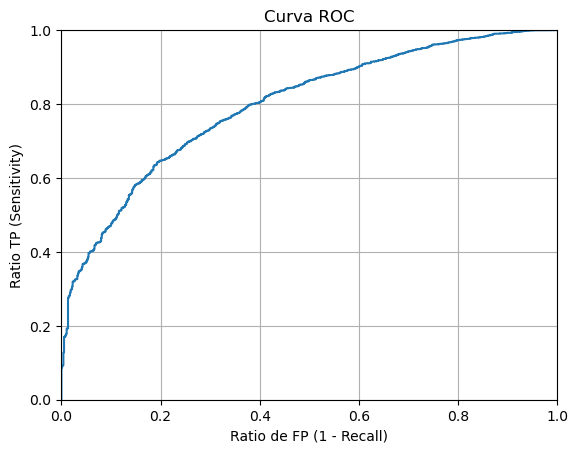

In [467]:
y_pred_prob_Forest = final_Forest.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_Forest)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

In [468]:
thresholds

array([       inf, 0.99986182, 0.99979485, ..., 0.03557262, 0.03473928,
       0.01377344])

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

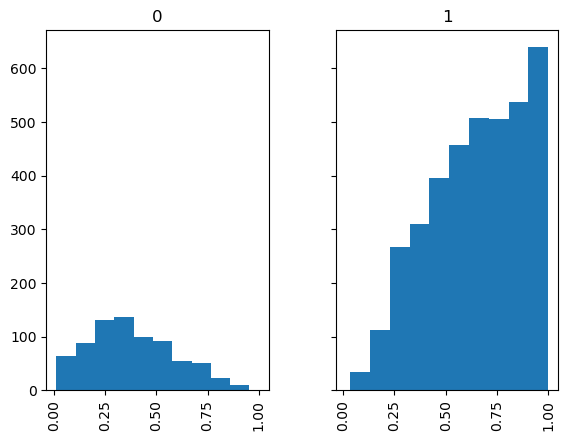

In [469]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_Forest, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [515]:
op_thres_Random = 0.3

evaluate_threshold(op_thres_Random)

Sensitivity: 0.9104913678618858
Recall: 0.3813333333333333


In [517]:
probs_For_opt = final_Forest.predict_proba(X_test_scaled)[:, 1]  
pred_thres_For_opt = (probs_For_opt >= op_thres_Random).astype(int) 

In [518]:
print(confusion_matrix(expected_For_opt, pred_thres_For_opt))

[[ 285  465]
 [ 337 3428]]


In [521]:
print(classification_report(expected_For_opt, pred_thres_For_opt))

              precision    recall  f1-score   support

           0       0.46      0.38      0.42       750
           1       0.88      0.91      0.90      3765

    accuracy                           0.82      4515
   macro avg       0.67      0.65      0.66      4515
weighted avg       0.81      0.82      0.82      4515



In [525]:
print(roc_auc_score(expected_For_opt, predicted_For_opt))

0.7174900398406374


## 7.2 Clasificador MLP

### 7.2.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [549]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 6

Hiperparametros base para cada caso.

In [552]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [555]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [558]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

Al igual que se ha realizado distintos preprocesados al entrenamiento, hay que realizarlos al conjunto de test para obtener resultados coherentes.

In [561]:
X_test_scaled = prep.transform(X_test)

### 7.2.2 Optimizacion

No se vio necesario modificar los hiperparámetros de este caso, simplemente se eliminaron algunas posibilidades entre las *hidden_layers* al ver que no terminaban de funcionar en el anterior *notebook*.

Se calcula el tiempo que ha tardado en minutos.

Se escoge el mejor parámetro y su  precisión asociada.

Observamos los mejores 10 casos para analizar varias posibilidades.

### 7.2.3 Entrenamiento y evaluacion con hiperparametros optimizados

#### - Definicion y entrenamiento

Definimos los mejores parámetros.

In [564]:
params_final_Mlp = {
    'activation': 'tanh', 
    'alpha': 0.01, 
    'batch_size': 600,
    'hidden_layer_sizes': (100, 50, 25), 
    'learning_rate': 'constant', 
    'learning_rate_init': 0.01, 
    'solver': 'adam',
    'max_iter': 1000, 
    'early_stopping': True, 
    'validation_fraction': 0.15, 
    'random_state': seed
}

Definimos el modelo desagregando el diccionario.

In [567]:
final_Mlp = MLPClassifier(**params_final_Mlp)

Entrenamos el modelo.

In [576]:
final_Mlp.fit(X_resampled, y_resampled)

predicted_MLP_opt = final_Mlp.predict(X_test_scaled)
expected_MLP_opt = y_test

#### - Matriz de confusion y F-score

Se ha obtenido una mejora en el f1-score de los 0s.

In [579]:
print(confusion_matrix(expected_MLP_opt, predicted_MLP_opt))

[[ 330  420]
 [ 474 3291]]


In [580]:
print(classification_report(expected_MLP_opt, predicted_MLP_opt))

              precision    recall  f1-score   support

           0       0.41      0.44      0.42       750
           1       0.89      0.87      0.88      3765

    accuracy                           0.80      4515
   macro avg       0.65      0.66      0.65      4515
weighted avg       0.81      0.80      0.80      4515



#### - ROC y AUC

La distribución de probabilidades de los 0s y 1s esta más polarizada permitiendo ajustar mejor el threshold. En cambio, la AUC score se mejora de 0.61 a 0.65, pero no se llega al siguiente intervalo de clasificación (es decir, sigue siendo una D).

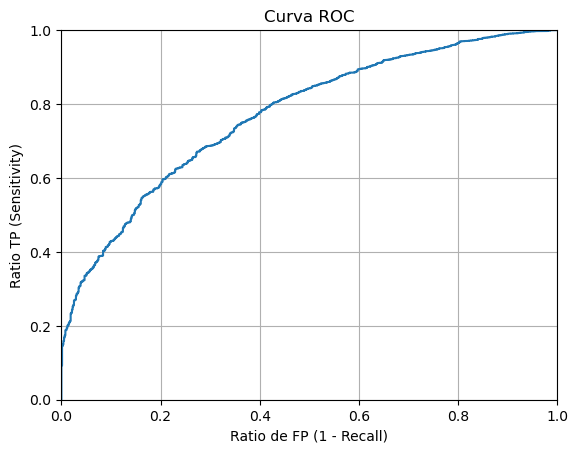

In [584]:
y_pred_prob_Forest = final_Mlp.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_Forest)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

In [586]:
thresholds

array([       inf, 0.99425738, 0.97610623, ..., 0.15548736, 0.15443916,
       0.13764927])

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

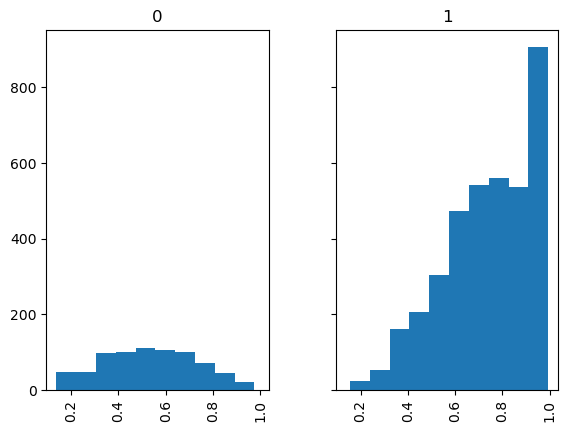

In [588]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_Forest, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [658]:
op_thres_MLP = 0.4

evaluate_threshold(op_thres_MLP)

Sensitivity: 0.9407702523240372
Recall: 0.272


In [660]:
probs_MLP_opt = final_Forest.predict_proba(X_test_scaled)[:, 1]  
pred_thres_MLP_opt = (probs_MLP_opt >= op_thres_MLP).astype(int) 

In [661]:
print(confusion_matrix(expected_MLP_opt, pred_thres_MLP_opt))

[[ 434  316]
 [ 652 3113]]


In [664]:
print(classification_report(expected_MLP_opt, pred_thres_MLP_opt))

              precision    recall  f1-score   support

           0       0.40      0.58      0.47       750
           1       0.91      0.83      0.87      3765

    accuracy                           0.79      4515
   macro avg       0.65      0.70      0.67      4515
weighted avg       0.82      0.79      0.80      4515



In [668]:
print(roc_auc_score(expected_MLP_opt, predicted_MLP_opt))

0.6570517928286852


#### - Curva de pérdidas y scores de validación

Se observa que se ejecutan muchas menos iteraciones debido al early_stopped. El motivo es que esta converguiendo las perdidas mucho más rapido. Esto supone que las *validation_scores_* sean mucho más variables al estar siendo analizado en menos iteraciones.

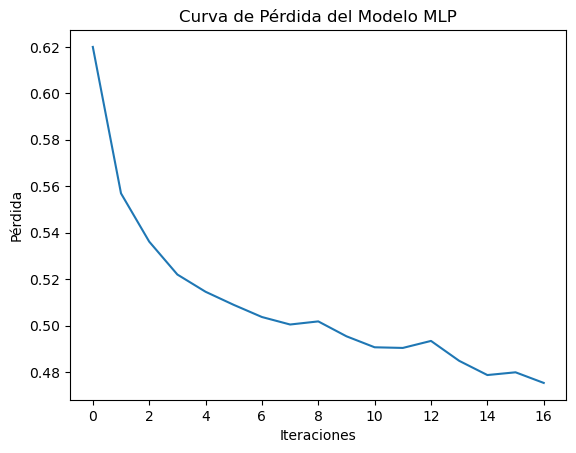

In [671]:
loss_values = final_Mlp.loss_curve_

plt.plot(loss_values)
plt.title('Curva de Pérdida del Modelo MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.show()

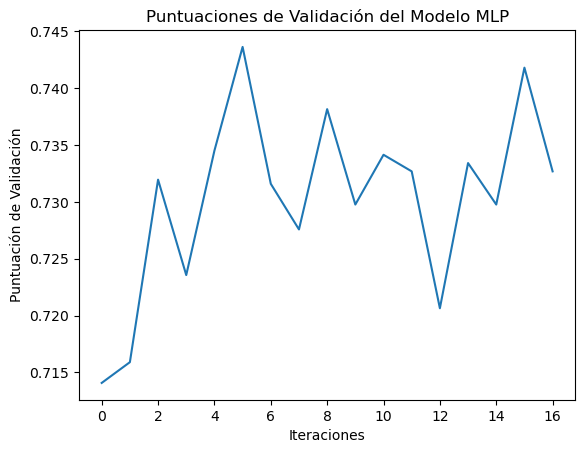

In [673]:
validation_scores = final_Mlp.validation_scores_

plt.plot(validation_scores)
plt.title('Puntuaciones de Validación del Modelo MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Puntuación de Validación')
plt.show()

## 7.3 Clasificador KNN

### 6.4.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [176]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [178]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [180]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [182]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [184]:
pca = PCA()
X_pca_full = pca.fit_transform(X_resampled)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_comp = np.argmax(cumulative_variance_ratio >= 0.95) + 1
X_pca = X_pca_full[:, :n_comp]

Al igual que se ha realizado distintos preprocesados al entrenamiento, hay que realizarlos al conjunto de test para obtener resultados coherentes.

No es necesario realizar las tecnicas de muestreo ya que eso son técnicas para balancear nuestro conjunto de entrenamiento. Solamente es necesario realizar la misma estandarización de las características y aplicar la misma reducción de dimensionalidad.

In [186]:
X_test_scaled = prep.transform(X_test)
X_test_pca_full = pca.transform(X_test_scaled)
X_test_pca = X_test_pca_full[:, :n_comp]

### 6.4.2 Definicion

Definimos el modelo básico.

In [189]:
model_KNN = KNeighborsClassifier()

### 6.4.3 Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [192]:
model_KNN.fit(X_pca, y_resampled)

predicted_KNN = model_KNN.predict(X_test_pca)
expected_KNN = y_test

In [193]:
accuracy_score(expected_KNN, predicted_KNN)

0.6717607973421927

### 6.4.4 Null accuracy

Nuestra exactitud es de 0.6801, la cual es peor que la *null accuracy*, es decir, ahora mismo no tenemos un buen modelo ya que se predecirían un mayor número de resultados en el caso de siempre predecir la clase mayoritaria.

### 6.4.5 Matriz de confusion y F-score

Se muestra la matriz de confusión y el informe de clasificación.

In [198]:
print(confusion_matrix(expected_KNN, predicted_KNN))

[[ 482  268]
 [1214 2551]]


In [199]:
print(classification_report(expected_KNN, predicted_KNN))

              precision    recall  f1-score   support

           0       0.28      0.64      0.39       750
           1       0.90      0.68      0.77      3765

    accuracy                           0.67      4515
   macro avg       0.59      0.66      0.58      4515
weighted avg       0.80      0.67      0.71      4515



Se observa lo que hemos estado comentando durante todo el documento, tenemos un f1-score del 0.78 para los 1s mientras que estamos obteniendo un 0.39 para los 0s.

### 6.4.6 ROC y AUC

Evaluamos la ROC-AUC score. Para ello representamos primero la curva de ROC.

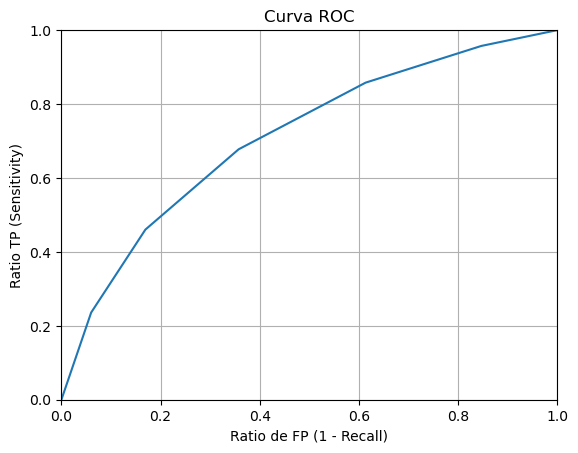

In [203]:
y_pred_prob_KNN = model_KNN.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_KNN)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

Y mostramos sus thresholds.

In [205]:
thresholds

array([inf, 1. , 0.8, 0.6, 0.4, 0.2, 0. ])

La siguiente gráfica muestra las probabilidades de predicción en función de los umbrales.

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

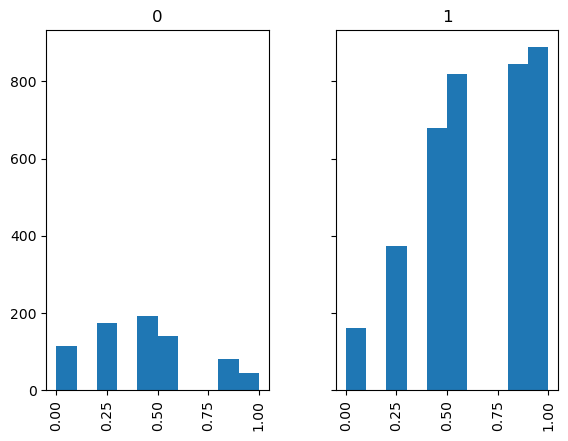

In [207]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_KNN, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

Se muestra unos resultados muy balanceados en el 0s excepto cuando su threshold es 1, mientras que en el caso de los 1s mantiene una tendencia ascendente.

In [209]:
best_thres_KNN = 0.6

evaluate_threshold(best_thres_KNN)

Sensitivity: 0.4602921646746348
Recall: 0.8306666666666667


Con este valor se obtienen los siguientes resultados. Primero se recalculan las predicciones.

In [211]:
probs_KNN = model_KNN.predict_proba(X_test_pca)[:, 1]  
pred_thres_KNN = (probs_KNN >= best_thres_KNN).astype(int) 

Se evalua la matriz de confusión.

In [213]:
print(confusion_matrix(expected_KNN, pred_thres_KNN))

[[ 482  268]
 [1214 2551]]


Y también se analiza el informe de la clasificación.

In [215]:
print(classification_report(expected_KNN, pred_thres_KNN))

              precision    recall  f1-score   support

           0       0.28      0.64      0.39       750
           1       0.90      0.68      0.77      3765

    accuracy                           0.67      4515
   macro avg       0.59      0.66      0.58      4515
weighted avg       0.80      0.67      0.71      4515



Como se puede observar no hay cambios respecto a no utilizar threshold, ya que nuestro mejor caso era con el umbral igual a 0.5, es decir, el valor por defecto.

Finalmente se calcula el valor de AUC.

In [218]:
print(roc_auc_score(expected_KNN, predicted_KNN))

0.6601115537848606


Se ha obtenido un valor entre 0.6 y 0.7, es decir, el modelo se considerá como pobre o *D*.

### 6.4.7 Optimizacion

Antes de nada, observamos cuales son los parámetros de nuestro modelo.

In [222]:
model_KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Ahora seleccionamos los hiperparámetros a evaluar mediante un GridSearchCV. Como se evalua mediante un *cross validation*, siempre escogeremos los casos 3 o 4 de preprocesado para falsear menos los datos.

Estos hiperparámetros son:
* n_neighbors: representa el número de vecinos a considerar en el modelo KNN
* weights: define cómo se ponderan los vecinos al calcular la predicción.
* algorithm: define el algoritmo utilizado para encontrar los vecinos más cercanos
* p: representa el parámetro de la distancia de Minkowski.
* leaf_size: valores más bajos pueden hacer la búsqueda más precisa pero más lenta.
* metric: define la métrica de distancia utilizada

Se calcula el tiempo que ha tardado en minutos.

### 6.4.8 Entramiento y evaluacion con hiperparametros optimizados

#### - Definicion

Definimos los mejores parámetros (no se define con *grid_search.best_params_* para probar varias opciones de forma sencilla).

In [228]:
params_final_KNN = {
    "n_neighbors": 11, 
    "leaf_size": 30, 
    "metric": "minkowski", 
    "p": 1, 
    "weights": "uniform", 
    "algorithm": "auto"
}

Definimos el modelo desagregando el diccionario.

In [230]:
final_KNN = KNeighborsClassifier(**params_final_KNN)

#### - Entrenamiento y evaluacion

Entrenamos el modelo y realizamos la predicción.

In [233]:
final_KNN.fit(X_pca, y_resampled)

predicted_KNN_opt = final_KNN.predict(X_test_pca)
expected_KNN_opt = y_test

Evaluamos la metrica obtenida.

In [235]:
accuracy_score(expected_KNN_opt, predicted_KNN_opt)

0.6888150609080842

#### - Matriz de confusion y F-score

La matriz de confusión y el informe de clasificación también es muy similar.

In [238]:
print(confusion_matrix(expected_KNN_opt, predicted_KNN_opt))

[[ 495  255]
 [1150 2615]]


In [239]:
print(classification_report(expected_KNN_opt, predicted_KNN_opt))

              precision    recall  f1-score   support

           0       0.30      0.66      0.41       750
           1       0.91      0.69      0.79      3765

    accuracy                           0.69      4515
   macro avg       0.61      0.68      0.60      4515
weighted avg       0.81      0.69      0.73      4515



#### - ROC y AUC

Cómo se ha visto antes el mejor threshold será 0.5, así que no se realiza este apartado.

### 6.4.9 Conclusiones

A continuación se muestra los resultados de los modelos optimizados y sin optimizar. Cabe recalcar que se probaron otros cuatro conjuntos de hiperparámetros para la mayoria de los casos de preprocesado, pero se acabó considerando absurdo porque mejoraba o empeoraba 0.01 en diversos valores.

Caso 1 : 

              precision    recall  f1-score   support

           0       0.27      0.64      0.38       750
           1       0.90      0.65      0.76      3765

    accuracy                           0.65      4515

Caso 2 : 

              precision    recall  f1-score   support

           0       0.27      0.59      0.37       750
           1       0.89      0.69      0.78      3765

    accuracy                           0.67      4515

Caso 3 : 

              precision    recall  f1-score   support

           0       0.30      0.66      0.41       750
           1       0.91      0.69      0.79      3765

    accuracy                           0.69      4515

Caso 4 : 

              precision    recall  f1-score   support

           0       0.31      0.66      0.42       750
           1       0.91      0.71      0.80      3765

    accuracy                           0.70      4515

Caso 5 : 

              precision    recall  f1-score   support

           0       0.31      0.47      0.38       750
           1       0.88      0.80      0.84      3765

    accuracy                           0.74      4515

Caso 6 : 

              precision    recall  f1-score   support

           0       0.33      0.45      0.38       750
           1       0.88      0.82      0.85      3765

    accuracy                           0.76      

En nuestro caso el mejor caso es el 6 o el 4 si nos fijamos en el f1 score de los 0s.

## 6.5 Clasificador GBC

### 6.5.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [249]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [251]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [253]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [255]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [257]:
pca = PCA()
X_pca_full = pca.fit_transform(X_resampled)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_comp = np.argmax(cumulative_variance_ratio >= 0.95) + 1
X_pca = X_pca_full[:, :n_comp]

Al igual que se ha realizado distintos preprocesados al entrenamiento, hay que realizarlos al conjunto de test para obtener resultados coherentes.

No es necesario realizar las tecnicas de muestreo ya que eso son técnicas para balancear nuestro conjunto de entrenamiento. Solamente es necesario realizar la misma estandarización de las características y aplicar la misma reducción de dimensionalidad.

In [259]:
X_test_scaled = prep.transform(X_test)
X_test_pca_full = pca.transform(X_test_scaled)
X_test_pca = X_test_pca_full[:, :n_comp]

### 6.5.2 Definicion

Definimos el modelo básico.

In [262]:
model_GBC = GradientBoostingClassifier()

### 6.5.3 Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [265]:
model_GBC.fit(X_pca, y_resampled)

predicted_GBC = model_GBC.predict(X_test_pca)
expected_GBC = y_test

In [266]:
accuracy_score(expected_GBC, predicted_GBC)

0.7306755260243633

### 6.5.4 Null accuracy

Nuestra exactitud es de 0.7333, la cual es peor que la null accuracy, es decir, ahora mismo no tenemos un buen modelo ya que se predecirían un mayor número de resultados en el caso de siempre predecir la clase mayoritaria.

### 6.5.5 Matriz de confusion y F-score

Se muestra la matriz de confusión y el informe de clasificación.

In [271]:
print(confusion_matrix(expected_GBC, predicted_GBC))

[[ 486  264]
 [ 952 2813]]


In [272]:
print(classification_report(expected_GBC, predicted_GBC))

              precision    recall  f1-score   support

           0       0.34      0.65      0.44       750
           1       0.91      0.75      0.82      3765

    accuracy                           0.73      4515
   macro avg       0.63      0.70      0.63      4515
weighted avg       0.82      0.73      0.76      4515



Se observa lo que hemos estado comentando durante todo el documento, tenemos un f1-score del 0.44 para los 1s mientras que estamos obteniendo un 0.73 para los 0s.

### 6.5.6 ROC y AUC

Evaluamos la ROC-AUC score. Para ello representamos primero la curva de ROC.

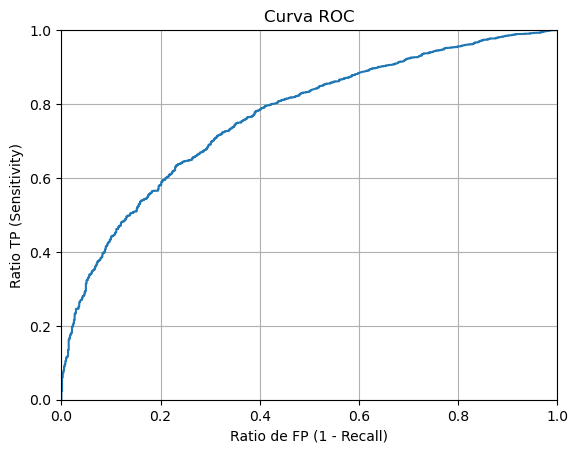

In [276]:
y_pred_prob_GBC = model_GBC.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_GBC)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

Y mostramos sus thresholds.

In [278]:
thresholds

array([       inf, 0.97098606, 0.94705255, ..., 0.14135635, 0.13339811,
       0.06218376])

La siguiente gráfica muestra las probabilidades de predicción en función de los umbrales.

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

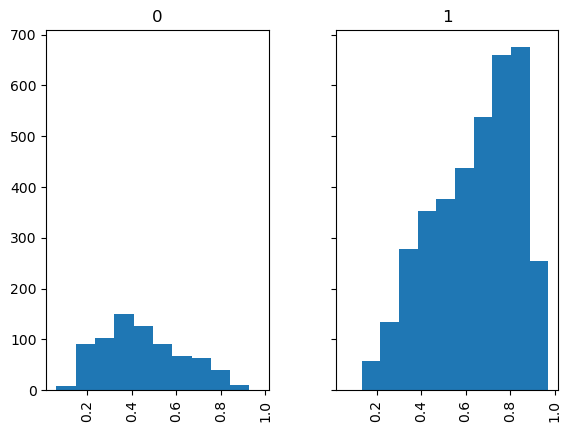

In [280]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_GBC, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

Se muestra que los mejores resultados para ambas clases se obtiene con el *threshold* igual a 0.75.

In [282]:
best_thres_GBC = 0.4

evaluate_threshold(best_thres_GBC)

Sensitivity: 0.8610889774236388
Recall: 0.44799999999999995


Con este valor se obtienen los siguientes resultados. Primero se recalculan las predicciones.

In [284]:
probs_GBC = model_GBC.predict_proba(X_test_pca)[:, 1]  
pred_thres_GBC = (probs_GBC >= best_thres_GBC).astype(int) 

Se evalua la matriz de confusión.

In [286]:
print(confusion_matrix(expected_GBC, pred_thres_GBC))

[[ 336  414]
 [ 523 3242]]


Y también se analiza el informe de la clasificación.

In [288]:
print(classification_report(expected_GBC, pred_thres_GBC))

              precision    recall  f1-score   support

           0       0.39      0.45      0.42       750
           1       0.89      0.86      0.87      3765

    accuracy                           0.79      4515
   macro avg       0.64      0.65      0.65      4515
weighted avg       0.80      0.79      0.80      4515



Como se puede observar se obtiene una mejora significante en accuracy y f1-score en 1 a cambio de perder f1-score en 0s

Finalmente se calcula el valor de AUC.

In [291]:
print(roc_auc_score(expected_GBC, predicted_GBC))

0.6975723771580347


Se ha obtenido un valor entre 0.6 y 0.7, es decir, el modelo se considerá como pobre o *D*.

### 6.5.7 Optimizacion

Antes de nada, observamos cuales son los parámetros de nuestro modelo.

In [295]:
model_GBC.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Ahora seleccionamos los hiperparámetros a evaluar mediante un GridSearchCV. Como se evalua mediante un cross validation, siempre escogeremos los casos 3 o 4 de preprocesado para falsear menos los datos.

Estos son los hiperparámetros más importantes:
* learning_rate: Controla la contribución de cada árbol para evitar sobreajuste.ç
* n_estimators: Número de árboles en el modelo, afectando la capacidad de aprendizaje.
* max_depth: Profundidad máxima de los árboles, evitando sobreajuste o subajuste.
* min_samples_split: Mínimo de muestras necesarias para dividir un nodo, regulando la complejidad.
* min_samples_leaf: Mínimo de muestras en una hoja para evitar divisiones insignificantes.
* subsample: Proporción de datos usados en cada iteración, reduciendo varianza.
* loss: Función de pérdida optimizada (ej. log_loss para clasificación).

Se calcula el tiempo que ha tardado en minutos.

### 6.5.8 Entramiento y evaluacion con hiperparametros optimizados

#### - Definicion

Definimos los mejores parámetros (no se define con *grid_search.best_params_* para probar varias opciones de forma sencilla).

In [301]:
params_final_GBC = {
    'ccp_alpha': 0.0,
    'criterion': 'friedman_mse',
    'max_depth': 3,
    'max_features': None,
    'min_impurity_decrease': 0.01,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'n_iter_no_change': None,
    'subsample': 0.8,
    'validation_fraction': 0.2,
    'random_state': seed
}

Definimos el modelo desagregando el diccionario.

In [303]:
final_GBC = GradientBoostingClassifier(**params_final_GBC)

#### - Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [306]:
final_GBC.fit(X_pca, y_resampled)

predicted_GBC_opt = final_GBC.predict(X_test_pca)
expected_GBC_opt = y_test

In [307]:
accuracy_score(expected_GBC_opt, predicted_GBC_opt)

0.7275747508305648

#### - Matriz de confusion y F-score

La matriz de confusión y el informe de clasificación también es muy similar.

In [310]:
print(confusion_matrix(expected_GBC_opt, predicted_GBC_opt))

[[ 488  262]
 [ 968 2797]]


In [311]:
print(classification_report(expected_GBC_opt, predicted_GBC_opt))

              precision    recall  f1-score   support

           0       0.34      0.65      0.44       750
           1       0.91      0.74      0.82      3765

    accuracy                           0.73      4515
   macro avg       0.62      0.70      0.63      4515
weighted avg       0.82      0.73      0.76      4515



### 6.5.9 Conclusiones

A continuación se muestra los resultados de los modelos optimizados y sin optimizar. Cabe recalcar que se probaron otros cuatro conjuntos de hiperparámetros para la mayoria de los casos de preprocesado, pero se acabó considerando absurdo porque mejoraba o empeoraba 0.01 en diversos valores.

Caso 1 : 

              precision    recall  f1-score   support

           0       0.31      0.65      0.42       750
           1       0.91      0.71      0.80      3765

    accuracy                           0.70      4515

Caso 2 : 

              precision    recall  f1-score   support

           0       0.32      0.66      0.43       750
           1       0.91      0.71      0.80      3765

    accuracy                           0.71      4515

Caso 3 : 

              precision    recall  f1-score   support

           0       0.34      0.64      0.44       750
           1       0.91      0.75      0.82      3765

    accuracy                           0.73      4515

Caso 4 : 

              precision    recall  f1-score   support

           0       0.34      0.62      0.44       750
           1       0.91      0.76      0.83      3765

    accuracy                           0.73      4515

Caso 5 : 

              precision    recall  f1-score   support

           0       0.39      0.38      0.39       750
           1       0.88      0.88      0.88      3765

    accuracy                           0.80      4515

Caso 6 : 

              precision    recall  f1-score   support

           0       0.41      0.41      0.41       750
           1       0.88      0.88      0.88      3765

    accuracy                           0.80      4515

En nuestro caso el mejor caso es el 6 o el 4 si nos fijamos en el f1 score de los 0s.

# 7. Exportar CSV

## 7.1 Clasificador Random Forest

### 7.1.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [320]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 6

Hiperparametros base para cada caso.

In [322]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.6
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.3
    strategy_over = 0.6
    neighbors = 5

Se estandarizan los datos en función del caso.

In [324]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [326]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [328]:
pca_final = PCA()
X_pca_full_final = pca_final.fit_transform(X_resampled_final)

cumulative_variance_ratio_final = np.cumsum(pca_final.explained_variance_ratio_)
n_comp_final = np.argmax(cumulative_variance_ratio_final >= 0.95) + 1
X_pca_final = X_pca_full_final[:, :n_comp_final]

Se preprocesa el conjunto de test.

In [330]:
X_test_scaled_final = prep_final.transform(X_test_final)
X_test_pca_full_final = pca_final.transform(X_test_scaled_final)
X_test_pca_final = X_test_pca_full_final[:, :n_comp_final]

### 7.1.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test, y se modifica el umbral de probabilidades. En un principio, el valor del umbral era el de la variable *op_thres_Random*, pero se decidió finalmente que el valor del umbral fueran valores numéricos para que fuera más sencillo hacer diversas pruebas en Kaggle.

In [333]:
final_Forest.fit(X_pca_final, y_resampled_final)

probs_For_final = final_Forest.predict_proba(X_test_pca_final)[:, 1]  
pred_thres_For_final = (probs_For_final >= 0.5).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [335]:
df_accept_Random = pd.DataFrame(pred_thres_For_final, columns=['Accept'])

In [336]:
df_id = df_test['id'].reset_index(drop=True)

In [337]:
df_final_Random = pd.concat([df_id, df_accept_Random], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [339]:
df_final_Random['Accept'].value_counts()

Accept
1    2259
0    1025
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [341]:
df_final_Random.to_csv('./submit/xg.csv', index=False)

## 7.2 Clasificador MLP

### 7.2.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [345]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 6

Hiperparametros base para cada caso.

In [347]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.4
    strategy_over = 0.6
    neighbors = 10

Se estandarizan los datos en función del caso.

In [349]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [351]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [353]:
pca_final = PCA()
X_pca_full_final = pca_final.fit_transform(X_resampled_final)

cumulative_variance_ratio_final = np.cumsum(pca_final.explained_variance_ratio_)
n_comp_final = np.argmax(cumulative_variance_ratio_final >= 0.95) + 1
X_pca_final = X_pca_full_final[:, :n_comp_final]

Se preprocesa el conjunto de test.

In [355]:
X_test_scaled_final = prep_final.transform(X_test_final)
X_test_pca_full_final = pca_final.transform(X_test_scaled_final)
X_test_pca_final = X_test_pca_full_final[:, :n_comp_final]

### 7.2.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test, y se modifica el umbral de probabilidades.

In [358]:
final_Mlp.fit(X_pca_final, y_resampled_final)

probs_Mlp_final = final_Mlp.predict_proba(X_test_pca_final)[:, 1]  
pred_thres_Mlp_final = (probs_Mlp_final >= 0.6).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [360]:
df_accept_Mlp = pd.DataFrame(pred_thres_Mlp_final, columns=['Accept'])

In [361]:
df_id = df_test['id'].reset_index(drop=True)

In [362]:
df_final_Mlp = pd.concat([df_id, df_accept_Mlp], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [364]:
df_final_Mlp['Accept'].value_counts()

Accept
1    1679
0    1605
Name: count, dtype: int64

Comprobamos la curva de pérdidas y los scores de validación.

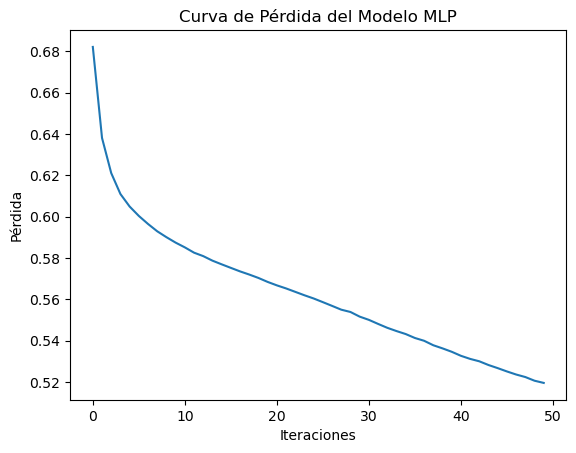

In [366]:
loss_values = final_Mlp.loss_curve_

plt.plot(loss_values)
plt.title('Curva de Pérdida del Modelo MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.show()

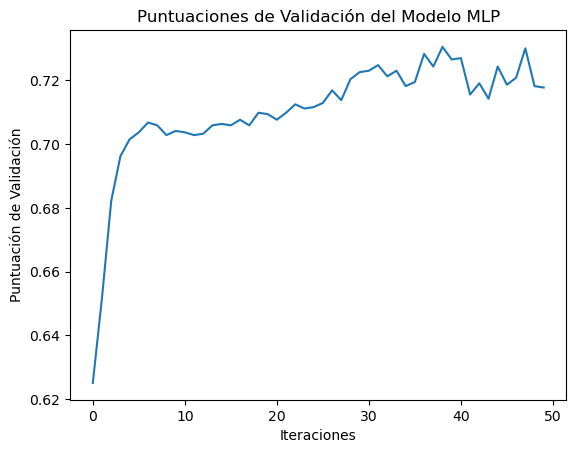

In [367]:
validation_scores = final_Mlp.validation_scores_

plt.plot(validation_scores)
plt.title('Puntuaciones de Validación del Modelo MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Puntuación de Validación')
plt.show()

Se transforma el *dataframe* a un archivo *CSV*.

In [369]:
df_final_Mlp.to_csv('./submit/mlp.csv', index=False)

## 7.3 Clasificador KNN

### 7.3.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [373]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [375]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.6
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [377]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [379]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [381]:
pca_final = PCA()
X_pca_full_final = pca_final.fit_transform(X_resampled_final)

cumulative_variance_ratio_final = np.cumsum(pca_final.explained_variance_ratio_)
n_comp_final = np.argmax(cumulative_variance_ratio_final >= 0.95) + 1
X_pca_final = X_pca_full_final[:, :n_comp_final]

Se preprocesa el conjunto de test.

In [383]:
X_test_scaled_final = prep_final.transform(X_test_final)
X_test_pca_full_final = pca_final.transform(X_test_scaled_final)
X_test_pca_final = X_test_pca_full_final[:, :n_comp_final]

### 7.3.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test.

In [386]:
final_KNN.fit(X_pca_final, y_resampled_final)

probs_KNN_final = final_KNN.predict_proba(X_test_pca_final)[:, 1]  
pred_thres_KNN_final = (probs_KNN_final >= 0.5).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [388]:
df_accept_KNN = pd.DataFrame(pred_thres_KNN_final, columns=['Accept'])

In [389]:
df_id = df_test['id'].reset_index(drop=True)

In [390]:
df_final_KNN = pd.concat([df_id, df_accept_KNN], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [392]:
df_final_KNN['Accept'].value_counts()

Accept
1    2016
0    1268
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [394]:
df_final_Random.to_csv('./submit/knn.csv', index=False)

## 7.4 Clasificador GBC

### 7.4.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [398]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [400]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.6
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [402]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [404]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [406]:
pca_final = PCA()
X_pca_full_final = pca_final.fit_transform(X_resampled_final)

cumulative_variance_ratio_final = np.cumsum(pca_final.explained_variance_ratio_)
n_comp_final = np.argmax(cumulative_variance_ratio_final >= 0.95) + 1
X_pca_final = X_pca_full_final[:, :n_comp_final]

Se preprocesa el conjunto de test.

In [408]:
X_test_scaled_final = prep_final.transform(X_test_final)
X_test_pca_full_final = pca_final.transform(X_test_scaled_final)
X_test_pca_final = X_test_pca_full_final[:, :n_comp_final]

### 7.4.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test, y se modifica el umbral de probabilidades.

In [411]:
final_GBC.fit(X_pca_final, y_resampled_final)

probs_GBC_final = final_GBC.predict_proba(X_test_pca_final)[:, 1]  
pred_thres_GBC_final = (probs_GBC_final >= 0.5).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [413]:
df_accept_GBC = pd.DataFrame(pred_thres_GBC_final, columns=['Accept'])

In [414]:
df_id = df_test['id'].reset_index(drop=True)

In [415]:
df_final_GBC = pd.concat([df_id, df_accept_GBC], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [417]:
df_final_GBC['Accept'].value_counts()

Accept
1    2209
0    1075
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [419]:
df_final_GBC.to_csv('./submit/gbc.csv', index=False)

## 7.5 Clasificador LinearSVC

### 7.5.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [423]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [425]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [427]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [429]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [431]:
pca_final = PCA()
X_pca_full_final = pca_final.fit_transform(X_resampled_final)

cumulative_variance_ratio_final = np.cumsum(pca_final.explained_variance_ratio_)
n_comp_final = np.argmax(cumulative_variance_ratio_final >= 0.95) + 1
X_pca_final = X_pca_full_final[:, :n_comp_final]

Se preprocesa el conjunto de test.

In [433]:
X_test_scaled_final = prep_final.transform(X_test_final)
X_test_pca_full_final = pca_final.transform(X_test_scaled_final)
X_test_pca_final = X_test_pca_full_final[:, :n_comp_final]

### 7.5.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test.

In [436]:
final_SVC.fit(X_pca_final, y_resampled_final)

pred_thres_SVC_final = final_SVC.predict(X_test_pca_final) 

NameError: name 'final_SVC' is not defined

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [ ]:
df_accept_SVC = pd.DataFrame(pred_thres_SVC_final, columns=['Accept'])

In [ ]:
df_id = df_test['id'].reset_index(drop=True)

In [ ]:
df_final_SVC = pd.concat([df_id, df_accept_SVC], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [ ]:
df_final_SVC['Accept'].value_counts()

Se transforma el *dataframe* a un archivo *CSV*.

In [ ]:
df_final_SVC.to_csv('./submit/sbc.csv', index=False)

## 7.6 Ensemble de los modelos por votacion

### 7.6.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [ ]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 6

Hiperparametros base para cada caso.

In [ ]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.6
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.4
    strategy_over = 0.8
    neighbors = 10

Se estandarizan los datos en función del caso.

In [ ]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [ ]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [ ]:
pca_final = PCA()
X_pca_full_final = pca_final.fit_transform(X_resampled_final)

cumulative_variance_ratio_final = np.cumsum(pca_final.explained_variance_ratio_)
n_comp_final = np.argmax(cumulative_variance_ratio_final >= 0.95) + 1
X_pca_final = X_pca_full_final[:, :n_comp_final]

Se preprocesa el conjunto de test.

In [ ]:
X_test_scaled_final = prep_final.transform(X_test_final)
X_test_pca_full_final = pca_final.transform(X_test_scaled_final)
X_test_pca_final = X_test_pca_full_final[:, :n_comp_final]

### 7.6.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test. Se ha decidido no incluir en el ensemble el clasificador LinearSVC por sus malos resultados.

In [ ]:
voting_clf = VotingClassifier( 
    estimators=[
        ('RF', final_Forest),
        ('MLP', final_Mlp),
        ('KNN', final_KNN),
        ('GBC', final_GBC)
    ],
    voting='soft',
    weights=[3, 4, 1, 3],
    n_jobs=-1
)

In [ ]:
voting_clf.fit(X_pca_final, y_resampled_final)


probs_Vote_final = voting_clf.predict_proba(X_test_pca_final)[:, 1]  
pred_thres_Vote_final = (probs_Vote_final >= 0.6).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [ ]:
df_accept_vote = pd.DataFrame(pred_thres_Vote_final, columns=['Accept'])

In [ ]:
df_id = df_test['id'].reset_index(drop=True)

In [ ]:
df_final_vote = pd.concat([df_id, df_accept_vote], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [ ]:
df_final_vote['Accept'].value_counts()

Se transforma el *dataframe* a un archivo *CSV*.

In [ ]:
df_final_vote.to_csv('./submit/vote.csv', index=False)